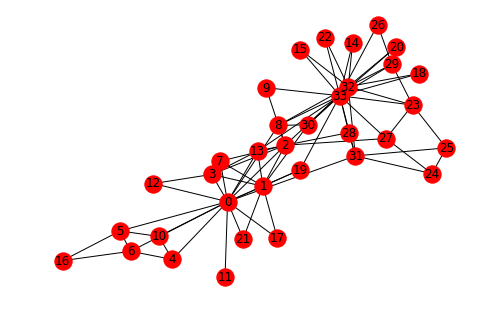

Communities with local maximal modularity:
Modularity:
0.359960552268243
Communities:
[{0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]


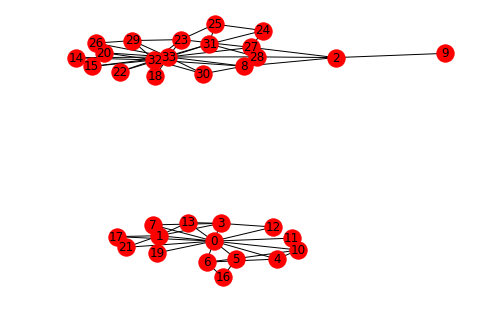

Modularity:
0.37245233399079447
Communities:
[{0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {24, 2, 27, 28}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 25, 26, 29, 30, 31}, {9}]


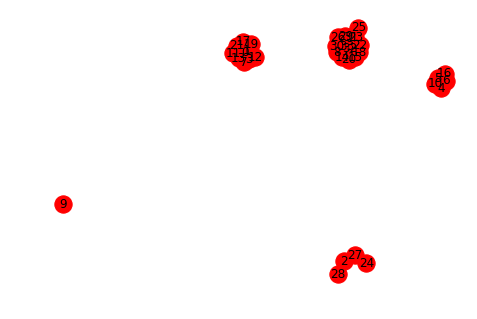

Modularity:
0.35256410256410226
Communities:
[{0, 1, 3, 7, 12, 13, 17, 19, 21}, {24, 2, 27, 28}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 29, 30}, {9}, {11}, {25, 31}, {26}]


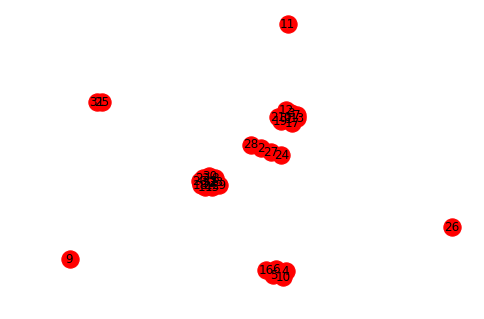

In [180]:
import matplotlib.pyplot as plt
import networkx as nx
from scipy.signal import find_peaks

#read graph from txt file
def readGraphFrom(file):
    G = nx.read_edgelist(file, create_using=nx.Graph(), nodetype=int)
    return G

def _partialEdgeBetweenness(G):
    #create ShortestPathGraph
    SPG = nx.Graph()
    #choose each node as root once
    for root in G:
        #calculate shotest path from each node to root and add edges to SPG
        for vertex in G:
            for shortest_path in nx.all_shortest_paths(G, source=vertex, target=root):
                 SPG.add_path(shortest_path)

        #calculate distance and weight for each node in SPG
        max_distance = 0
        for node in SPG:
            if node == root:
                SPG.nodes[node]['distance'] = 0
                SPG.nodes[node]['weight'] = 1
            else:
                distance = nx.shortest_path_length(SPG, source=root, target=node)
                #compute maximal distance from root (needed in later steps)
                if distance > max_distance:
                    max_distance = distance
                SPG.nodes[node]['distance'] = distance
                SPG.nodes[node]['weight'] = len(list(nx.all_shortest_paths(SPG, source=root, target=node)))
                
        #calculate partial betweenness scores for leaf edges
        for leaf in SPG:
            if SPG.nodes[leaf]['distance'] == max_distance:
                for node1, node2 in SPG.edges(leaf):
                    if node1 == leaf:
                        neighbor = node2
                    else:
                        neighbor = node1
                    SPG.edges[node1, node2][root] = SPG.nodes[neighbor]['weight']/SPG.nodes[leaf]['weight']
        
        #calculate partial betweenness scores for all other edges by decreasing maximal distance in each iteration
        while max_distance > 1:
            max_distance = max_distance-1
            for node in SPG:
                #only look at nodes at the current distance level
                if SPG.nodes[node]['distance'] == max_distance:
                    for node1, node2 in SPG.edges(node):
                        if node1 == node:
                            neighborUP = node2
                        else:
                            neighborUP = node1
                        if SPG.nodes[neighborUP]['distance'] == max_distance - 1:
                            sum_of_scores = 0
                            for node11, node22 in SPG.edges(node):
                                if node11 == node:
                                    neighborDOWN = node22
                                else:
                                    neighborDOWN = node11
                                if SPG.nodes[neighborDOWN]['distance'] == max_distance + 1:
                                    sum_of_scores = sum_of_scores + SPG.edges[neighborDOWN, node][root]
                            #set score for edge from current distance level to one level above (root is at top)
                            SPG.edges[node, neighborUP][root] = (1 + sum_of_scores)*SPG.nodes[neighborUP]['weight']/SPG.nodes[node]['weight']

    return SPG

#calculate edge betweenness for graph
def edgeBetweenness(G, node1, node2):
    NG = G.copy()
    
    for component in nx.connected_component_subgraphs(NG):
        #recalculate betweenness scores for graph components that contain at least one of the nodes from the last
        #removed edge
        if component.has_node(node1) or component.has_node(node2) or (node1 == 0 and node2 == 0):
            SPG = _partialEdgeBetweenness(component)
            
            for edge in SPG.edges:
                SPG.edges[edge]['weight'] = 0
                for root in SPG:
                    if root in SPG.edges[edge]:
                        SPG.edges[edge]['weight'] = SPG.edges[edge]['weight'] + SPG.edges[edge][root]
                        
            #copy final scores to new graph
            for edge in SPG.edges:
                NG.edges[edge]['weight'] = SPG.edges[edge]['weight']

    return NG

#determine edge with maximal betweenness score
def maxScoreEdge(G):
    maxScore = 0.0
    for edge in G.edges:
        if maxScore < G.edges[edge]['weight']:
            maxScore = G.edges[edge]['weight']
            edgeRemove = edge
    return edgeRemove

#remove edge from graph
def removeEdge(edge, G):
    G.remove_edge(edge[0], edge[1])
    return G



#G = readGraphFrom("graph.txt")
G = nx.karate_club_graph()
nx.draw(G, with_labels=True)
plt.show()

Graphs = [G]
Mod = [nx.algorithms.community.modularity(G, list(nx.connected_components(G)))]

num_iter = len(G.edges)
e = (0, 0)
NG = G.copy()

#iterate as many times as there are edges in the graph
while num_iter > 0:
    num_iter = num_iter - 1
    #calculate edge betweenness and store values in new graph 
    NG = edgeBetweenness(NG, e[0], e[1])
    e = maxScoreEdge(NG)
    removeEdge(e, NG)
    
    #add graph and modularity to list
    Graphs.append(NG)
    Mod.append(nx.algorithms.community.modularity(G, list(nx.connected_components(NG))))
        
#for g in Graphs:
#    print("Components:")
#    print(list(nx.connected_components(g)))
#    print(g.edges)
               
#for mod in Mod:
#    print("Modularity:")
#    print(mod)
    
print("Communities with local maximal modularity:")

#find local maxima in modularity array
index_max_mod, _ = find_peaks(Mod)

#print modularity and communities for local maxima
for i in index_max_mod:
    print("Modularity:")
    print(Mod[i])
    print("Communities:")
    print(list(nx.connected_components(Graphs[i])))
    nx.draw(Graphs[i], with_labels=True)
    plt.show()
    
#comp = nx.community.girvan_newman(G)
#tuple(sorted(c) for c in next(comp))